In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [33]:
def read_files(directory='../data/data/'):
    return [files for files in os.listdir(directory)]

def last_observed_benchmark(filenames, start, end):
    '''
    For a given start and end index iterate through dataframes to fetch the latest item
    and return it as prediction for that range
    '''
    predictions = []
    for i in range(start, end):
        df = pd.read_csv('../data/data/'+ str(i) + '.csv')
        recent_observation = df.iloc[-1:, 0:198]
        predictions.append(recent_observation)
    
    recent_observations_df = pd.concat(predictions, axis=0)
    recent_observations_df = recent_observations_df.set_index(np.arange(start - 1, end - 1))
    
    return recent_observations_df

def loss(y, y_pred):
    e = abs(y - y_pred)
    return e

In [24]:
filenames = read_files()
recent_observation_df = last_observed_benchmark(filenames, 1, 201)

In [31]:
## load true values
trueLabels = pd.read_csv('../data/trainLabels.csv')
y_true = trueLabels.iloc[:, 1:]

In [34]:
## lets take a look at the loss metric
e = loss(y_true, recent_observation_df)

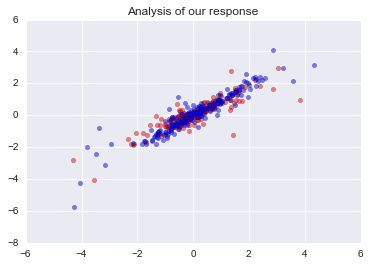

In [38]:
plt.scatter(y_true.iloc[:, 5], recent_observation_df.iloc[:, 5], c='r', alpha=.5)
plt.scatter(y_true.iloc[:, 6], recent_observation_df.iloc[:, 6], c='b', alpha=.5)
plt.title('Analysis of our response');

In [40]:
print 'Error on the training set is %f ' %e.mean(axis=1).mean()

Error on the training set is 0.440612 


## Submission

In [47]:
recent_observation_df_test = last_observed_benchmark(filenames, 201, 511)

In [61]:
recent_observation_df_test = recent_observation_df_test.set_index(np.arange(0, 310))

In [62]:
submission = pd.read_csv('../data/sampleSubmission.csv')

In [63]:
submission.iloc[:, 1:] = recent_observation_df_test

In [64]:
recent_observation_df_test.head()

,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10,...,O189,O190,O191,O192,O193,O194,O195,O196,O197,O198
0,-3.82,-0.88,0.54,0.08,-1.65,-2.80,-1.74,-5.16,-4.58,-5.23,...,-1.16,-3.50,-2.83,-2.03,-1.53,-2.50,-3.14,-6.31,-4.71,-3.53
1,6.79,-1.90,-0.65,0.14,-0.08,-1.74,-0.86,-1.17,-1.91,-0.50,...,-0.95,-2.09,-1.44,-0.67,-1.78,-2.33,-2.04,-5.38,-5.58,-2.60
2,2.06,-0.11,0.37,-0.13,0.36,0.82,0.97,1.61,1.14,2.93,...,0.42,0.99,0.47,0.29,-0.05,0.50,0.37,0.88,0.93,0.67
3,-0.62,-0.06,0.08,0.26,-0.37,0.26,7.22,-0.29,0.79,-1.71,...,0.09,0.26,-0.08,0.45,0.67,0.22,0.38,0.96,-0.42,1.06
4,-0.91,-0.84,-0.40,0.44,-2.77,-1.44,-1.72,-2.17,-3.19,-2.51,...,-0.89,-1.34,-1.77,-1.55,-1.16,-1.28,-1.35,-2.40,-2.61,-1.30


In [66]:
submission.to_csv('../submissions/last_observed_benchmark.csv', index=False)